# Case Study 7: Classify Unknown Dataset
## MSDS 7333: Quantifying the World
### Andy Nguyen, Michael J. Wolfe, & Joseph Caguioa

<font color="blue">

# Checklist
* EDA
* Imputation
* Discussing & implementing stratification, cross-validation strategies
* Discussing chosen accuracy metric
* Exploring different algorithms
* Discussing best model, including feature importance
* Quantifying ROI with cost-benefit matrix atop confusion matrix

# Current Tasks
* Plot remaining numeric features against target
* Investigate extra axes showing up on categorical vs target plots
* Create preliminary model (RF) to gauge feature importance and attempt imputation</font>

# Objective

Given an anonymized dataset with a binary target column y, use features x0 through x49 to build a model that would minimize penalty costs on an unseen dataset. 

| | | |
| --- | --- | --- |
| | True Positive: \\$0 | False Negative: <font color='red'>\\$500</font> |
| | False Positive: <font color='#8B0000'>\\$10</font> | True Negative: \\$0 |

Correct labels carry no penalty, while the dollar penalty associated with false negatives outweighs that of false positives by a factor of 50. Thus, our main priority is to create a model that prioritizes avoiding false negatives while also curtailing the number of false positives it produces. Our thought process and analysis of the model performance will be provided along the way where applicable.

# Setup

In [1]:
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Open zipped file located within same folder
zf = zipfile.ZipFile('final_project.csv.zip')
data = pd.read_csv(zf.open('final_project.csv'))

# Exploratory Data Analysis (EDA)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 51 columns):
x0     159974 non-null float64
x1     159975 non-null float64
x2     159962 non-null float64
x3     159963 non-null float64
x4     159974 non-null float64
x5     159963 non-null float64
x6     159974 non-null float64
x7     159973 non-null float64
x8     159979 non-null float64
x9     159970 non-null float64
x10    159957 non-null float64
x11    159970 non-null float64
x12    159964 non-null float64
x13    159969 non-null float64
x14    159966 non-null float64
x15    159965 non-null float64
x16    159974 non-null float64
x17    159973 non-null float64
x18    159960 non-null float64
x19    159965 non-null float64
x20    159962 non-null float64
x21    159971 non-null float64
x22    159973 non-null float64
x23    159953 non-null float64
x24    159972 non-null object
x25    159978 non-null float64
x26    159964 non-null float64
x27    159970 non-null float64
x28    159965 non-null

The dataset has 160,000 rows and 50 feature columns, with column 51 being the target variable. Forty-five of the features are numeric and the remaining five are shown as objects, likely categorical. All feature columns have less than 160,000 non-null entries, meaning that they all have some missing data.

In [4]:
np.transpose(data.head())

,0,1,2,3,4
x0,-0.166563,-0.149894,-0.321707,-0.245594,-0.273366
x1,-3.96159,-0.585676,-1.42982,5.07668,0.306326
x2,4.62111,27.8399,12.2516,-24.1496,-11.3526
x3,2.48191,4.15233,6.58687,3.63731,1.67676
x4,-1.80013,6.4268,-5.30465,6.50581,2.92844
x5,0.804684,-2.42694,-11.3111,2.29022,-0.616824
x6,6.71875,40.4771,17.8128,-35.1118,-16.5058
x7,-14.79,-6.72571,11.0606,-18.9136,27.5323
x8,-1.04067,0.896421,5.32588,-0.337041,1.19971
x9,-4.20495,0.330165,-2.63298,-5.56808,-4.3091


Looking at the first five rows of the dataset (here transcribed into columns) confirms that x24, x29, and x30 are indeed categorical, likely corresponding to continental region, month, and day of the week, respectively. Column x37, however, contains dollar amounts that should be treated as numeric variables. At first glance, x32, which contains percentages, appears as if it should be converted for similar reasons. However, as shown in the count plots below, it contains only 11 unique values, suggesting it should actually instead be left as a factor.

In [5]:
# Remove dollar signs from x37 and convert to float
data['x37'] = data['x37'].str.lstrip("$").apply(lambda x: float(x))

In [6]:
np.transpose(data.describe(include='all'))

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
x0,159974,NaN,NaN,NaN,-0.00102791,0.371137,-1.59263,-0.251641,-0.00204727,0.248532,1.60085
x1,159975,NaN,NaN,NaN,0.00135831,6.34063,-26.2783,-4.26097,0.00481273,4.28422,27.9882
x2,159962,NaN,NaN,NaN,-1.15014,13.2735,-59.394,-10.1665,-1.34093,7.87168,63.5457
x3,159963,NaN,NaN,NaN,-0.0246373,8.06503,-35.4766,-5.45444,-0.0314081,5.44518,38.906
x4,159974,NaN,NaN,NaN,-0.000549,6.38229,-28.4675,-4.31312,0.00085673,4.30666,26.2478
x5,159963,NaN,NaN,NaN,0.0135816,7.67008,-33.823,-5.14813,0.0141178,5.19075,35.5501
x6,159974,NaN,NaN,NaN,-1.67067,19.2987,-86.3545,-14.7801,-1.94859,11.4469,92.3906
x7,159973,NaN,NaN,NaN,-7.69279,30.5423,-181.507,-27.3248,-6.95679,12.2171,149.151
x8,159979,NaN,NaN,NaN,-0.0305403,8.90119,-37.691,-6.03106,-0.0168401,5.97235,39.0498
x9,159970,NaN,NaN,NaN,0.00546209,6.35504,-27.9807,-4.26062,0.00604512,4.30573,27.3778


This call for descriptive statistics confirms a successful conversion of x37 to a numeric feature. Many, but not all, of the columns have a mean close to zero. Values for the standard deviations, minima, and maxima vary wildly, suggesting different ranges that may need to be normalized. No unusual values pop out as alternative ways that missing data could have been encoded.

Additionally, the target variable looks as we expect, being only an integer value of either 0 or 1. The mean being lower than 0.5 indicates a class imbalance in favor of the true negatives.

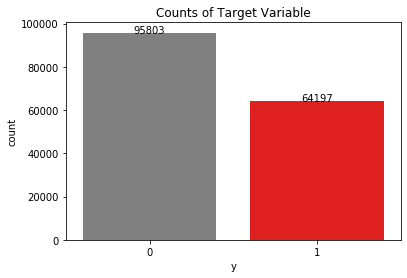

In [7]:
# Target palette
y_col = ['gray', 'red']

# Count plot of y
target_counts = data['y'].value_counts()
ax = sns.countplot(data = data, x = 'y', palette = y_col)
plt.title('Counts of Target Variable')
for value, count in target_counts.reset_index().iterrows():
    ax.text(value, count.y, count.y, color='black', ha='center')

This count plot confirms the distribution. There are 95,803 rows with the negative (0) result and 64,197 with the positive (1). Thus, for the target, the negatives occur more than the positives by a factor of 1.5. This will need to be accounted for during the train-test split before building the model.

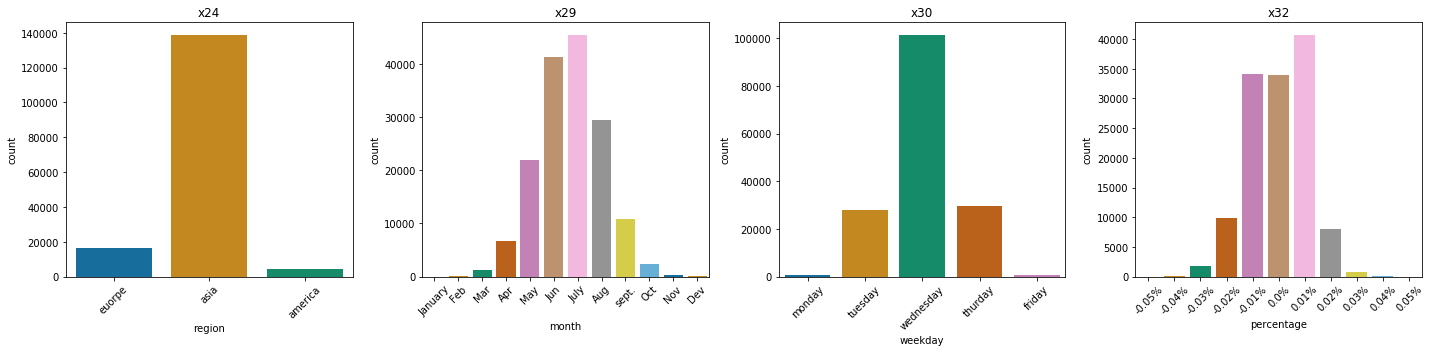

In [8]:
categorical_features = ['x24', 'x29', 'x30', 'x32']

# x-axis tick reorder
reorder_dict = {
    'x24': ['euorpe', 'asia', 'america'],
    'x29': ['January', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
            'July', 'Aug', 'sept.', 'Oct', 'Nov', 'Dev'],
    'x30': ['monday', 'tuesday', 'wednesday', 'thurday', 'friday'],
    'x32': ['-0.05%', '-0.04%', '-0.03%', '-0.02%', '-0.01%', 
            '0.0%','0.01%', '0.02%', '0.03%', '0.04%', '0.05%']
}

# x-axis labels
xaxis_dict = {
    'x24': 'region',
    'x29': 'month',
    'x30': 'weekday',
    'x32': 'percentage'
}

# Categorical feature plots
plt.close()
fig, ax = plt.subplots(1, len(categorical_features), figsize=(20, 5))
for i, categorical_feature in enumerate(data[categorical_features]):
    sns.countplot(data = data, x = categorical_feature, order = reorder_dict[categorical_feature], 
                  palette = 'colorblind', ax = ax[i]).set_title(categorical_feature)
    ax[i].tick_params(axis='x', labelrotation=45)
    ax[i].set_xlabel(xaxis_dict[categorical_feature])
plt.tight_layout()

Count plots for the categorical variables reveal significant imbalances. Within each factor, certain levels occur overwhelmingly often while others are exceedingly rare (e.g., "wednesday" versus "monday" in x30). This should be taken into consideration while forming our imputation strategy.

Of additional note is that while there are misspellings ("euorpe" and "Dev" and "thurday") and inconsistent formatting (period-less month abbreviations versus "sept." and "January"), these are consistently applied throughout the dataset. In other words, we do not need to correct for any sort of clerical errors to aggregate levels with the same meaning (e.g., "euorpe" with "europe").

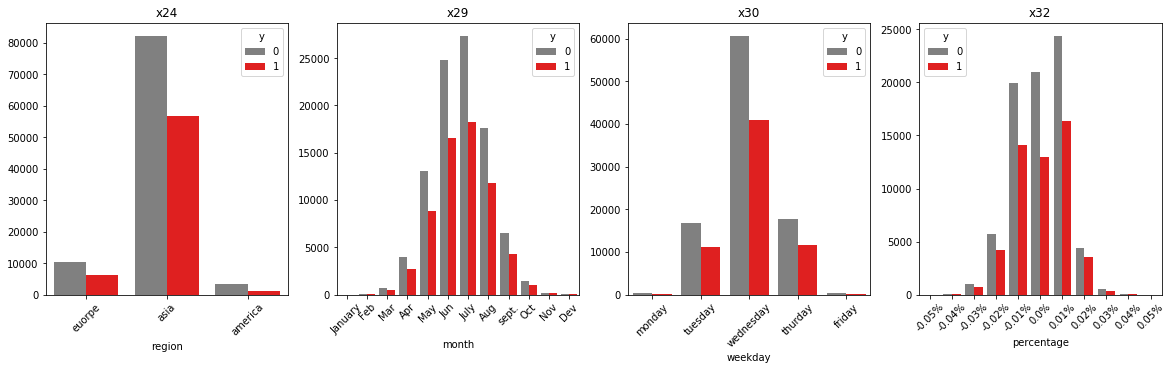

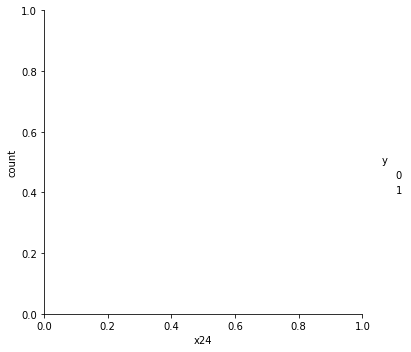

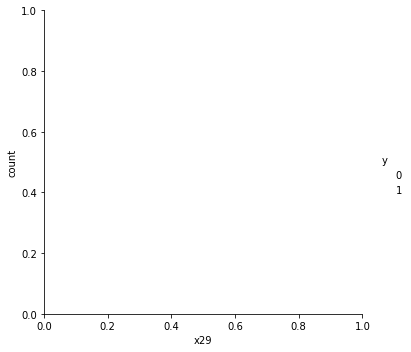

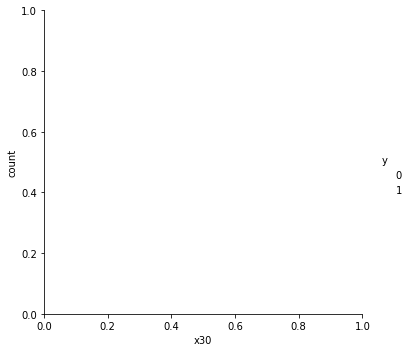

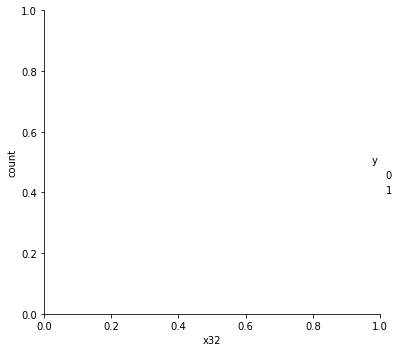

In [9]:
# Categorical features plotted by target y
plt.close()
fig, ax = plt.subplots(1, len(categorical_features), figsize=(20, 5))
for i, categorical_feature in enumerate(data[categorical_features]):
    sns.catplot(data = data, x = categorical_feature, order = reorder_dict[categorical_feature], 
                kind = 'count', hue = 'y', palette = y_col, ax = ax[i])
    ax[i].set_title(categorical_feature)
    ax[i].tick_params(axis='x', labelrotation=45)
    ax[i].set_xlabel(xaxis_dict[categorical_feature])
    ax[i].set_ylabel('')
plt.tight_layout()

Plotting the categorical variables on the target variable shows that the proportional breakdown for each level is roughly equivalent to the proportions of the target itself: 0 occurring 1.5 times more than 1. At a broad level, none of these features appear to be strongly capable at differentiating y.

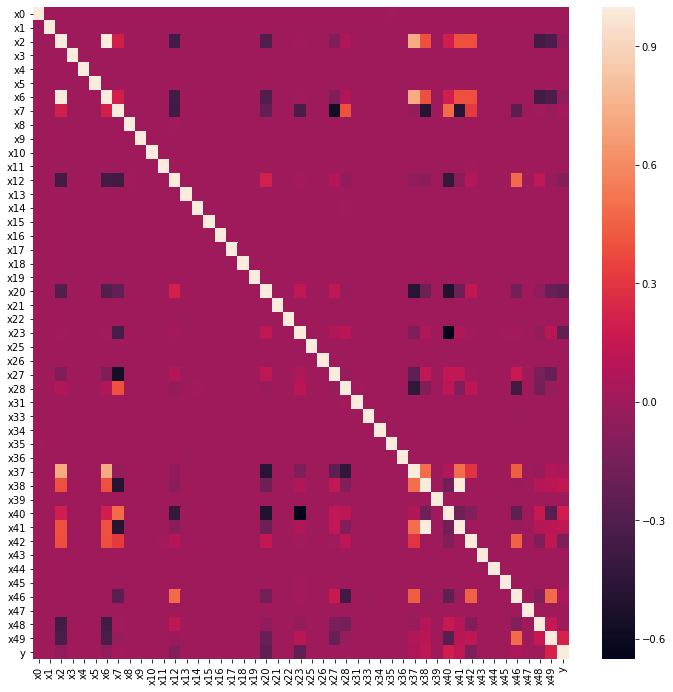

In [10]:
plt.figure(figsize = (12, 12))
corrMatrix = data.corr()
sns.heatmap(corrMatrix)
plt.show()

A heatmap of all the numeric variables shows that some variables are correlated with others—particularly x2, x6, x7, x12, x20, x23, x27, x28, x37, x38, x40, x41, x42, x46, 48, and x49—while others do not appear to demonstrate correlation at all. Of those mentioned, the majority also seem to show some correlation with y, albeit often moderate to weak, and could thus be anticipated to contribute as important features in an actual model.

# Imputation

In [11]:
data.isna().sum()

x0     26
x1     25
x2     38
x3     37
x4     26
x5     37
x6     26
x7     27
x8     21
x9     30
x10    43
x11    30
x12    36
x13    31
x14    34
x15    35
x16    26
x17    27
x18    40
x19    35
x20    38
x21    29
x22    27
x23    47
x24    28
x25    22
x26    36
x27    30
x28    35
x29    30
x30    30
x31    39
x32    31
x33    41
x34    41
x35    30
x36    27
x37    23
x38    31
x39    23
x40    36
x41    40
x42    26
x43    37
x44    40
x45    29
x46    31
x47    37
x48    32
x49    32
y       0
dtype: int64

In [12]:
data.isnull().any(axis = 1).sum()

1608

As previously established, all columns save for the target have some missing data. A cursory look reveals that no variable has more than 50 missing entries; each individual variable has less than 0.03% of its data missing. However, 1608 rows in total have at least one missing data entry. This is approximately 1% of the data. Complicating matters is the anonymized nature of the dataset, as context or background information is often useful to determine whether data for a particular variable is missing completely at random, missing at random, or missing not at random. Each of these categories benefits best from different imputation strategies.

While the simplest solution would be to simply remove any rows with missing data, this should be considered a last resort. Our need to eke out predictive power to help avoid false negatives gives further motivation to investigate whether imputing for these values provides any worthwhile benefit. Furthermore, it would be prudent to have a strategy in place to deal with any data in the unseen validation set, or even beyond that, real-life use cases, that contain missing values, as deleting those rows would likely not be a viable option.